<a href="https://colab.research.google.com/github/Shahriyar799/DataManagement/blob/main/Devorces_pred_AZE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import urllib.request
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

url = "https://admin.opendata.az/api/3/action/package_show?id=nikah-ve-bosanma-uzre-illik-gostericiler"

# Fetch metadata
with urllib.request.urlopen(url) as response:
    data = json.loads(response.read().decode())

# Extract resource URL (CSV)
resources = data["result"]["resources"]
csv_url = resources[0]["url"]

# Load CSV
df = pd.read_csv(csv_url, encoding="utf-8")




 TRANSFORM DATA (ROWS → COLUMNS)


In [ ]:


df_t = (
    df
    .set_index("Göstərici")
    .T
    .reset_index()
    .rename(columns={"index": "Il"})
)

df_t["Il"] = df_t["Il"].astype(int)



FORECAST EXPLANATORY VARIABLES

In [ ]:
X_year = df_t[['Il']]

#Forecast number of marriages
marriage_model = LinearRegression()
marriage_model.fit(X_year, df_t['Nikahların sayı'])

#Forecast marriage rate
marriage_rate_model = LinearRegression()
marriage_rate_model.fit(
    X_year,
    df_t['Nikahın ümumi əmsalı (hər 1000 nəfərə)']
)

# Forecast divorce rate
divorce_rate_model = LinearRegression()
divorce_rate_model.fit(
    X_year,
    df_t['Boşanmanın ümumi əmsalı (hər 1000 nəfərə)']
)



LinearRegression()

CREATE FUTURE YEARS (NEXT 5 YEARS)

In [ ]:
future_years = pd.DataFrame({
    "Il": [2024, 2025, 2026, 2027, 2028]
})

future_years['Nikahların sayı'] = marriage_model.predict(future_years[['Il']])

future_years['Nikahın ümumi əmsalı (hər 1000 nəfərə)'] = (
    marriage_rate_model.predict(future_years[['Il']])
)
future_years['Boşanmanın ümumi əmsalı (hər 1000 nəfərə)'] = (
    divorce_rate_model.predict(future_years[['Il']])
)
future_years




,Il,Nikahların sayı,Nikahın ümumi əmsalı (hər 1000 nəfərə),Boşanmanın ümumi əmsalı (hər 1000 nəfərə)
0,2024,73445.995074,7.284729,1.764778
1,2025,74227.493596,7.308079,1.808177
2,2026,75008.992118,7.331429,1.851576
3,2027,75790.490640,7.354778,1.894975
4,2028,76571.989163,7.378128,1.938374


FINAL DIVORCE MODEL

In [ ]:
X_final = df_t[
    [
        'Il',
        'Nikahların sayı',
        'Nikahın ümumi əmsalı (hər 1000 nəfərə)',
        'Boşanmanın ümumi əmsalı (hər 1000 nəfərə)'
    ]
]

y_final = df_t['Boşanmaların sayı']

divorce_model = LinearRegression()
divorce_model.fit(X_final, y_final)



future_divorces = divorce_model.predict(future_years)

forecast = pd.DataFrame({
    "Year": future_years["Il"],
    "Predicted divorces": future_divorces.round()
})

print(" Divorce forecast for next 5 years:")
print(forecast)



 Divorce forecast for next 5 years:
   Year  Predicted divorces
0  2024             17679.0
1  2025             18179.0
2  2026             18679.0
3  2027             19179.0
4  2028             19678.0



VISUALIZATION

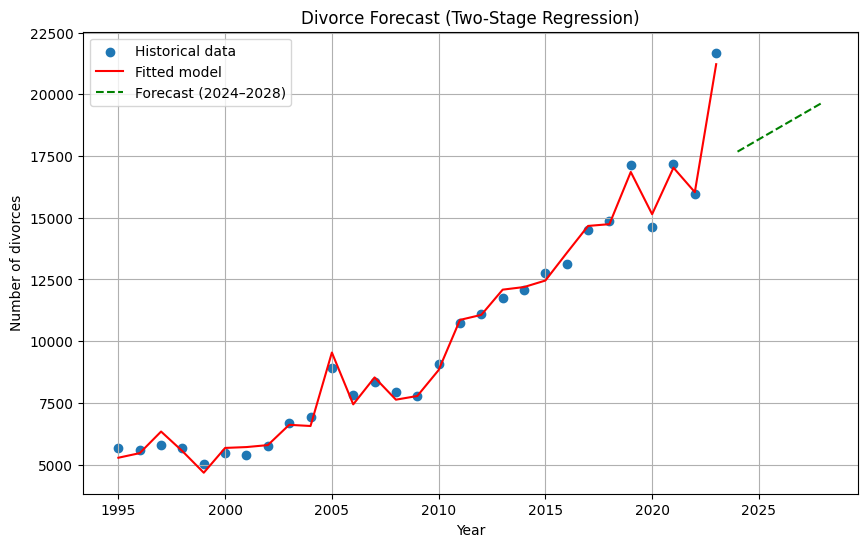

In [ ]:


plt.figure(figsize=(10,6))

plt.scatter(
    df_t['Il'],
    df_t['Boşanmaların sayı'],
    label="Historical data"
)

plt.plot(
    df_t['Il'],
    divorce_model.predict(X_final),
    color="red",
    label="Fitted model"
)

plt.plot(
    future_years['Il'],
    future_divorces,
    linestyle="--",
    color="green",
    label="Forecast (2024–2028)"
)

plt.xlabel("Year")
plt.ylabel("Number of divorces")
plt.title("Divorce Forecast (Two-Stage Regression)")
plt.legend()
plt.grid(True)
plt.show()